Title:


Introduction:
Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:
Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis. 

Links to potential datasets:

Sunshine hours for cities:
https://data.world/makeovermonday/2019w44


In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




In [2]:
url <- "https://github.com/anh-dong/dsci-100-2023w1-group-33/blob/main/data/imdb_top_1000.csv?raw=true"
movies <- read_csv(url) |>
    select(-Poster_Link, -Overview)
movies
# selectors <- paste()
# Data from https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

Rows: 499 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Poster_Link, Series_Title, Certificate, Runtime, Genre, Overview, ...
dbl  (4): Released_Year, IMDB_Rating, Meta_score, No_of_Votes
num  (1): Gross

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
The Shawshank Redemption,1994,A,142 min,Drama,9.3,80,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
The Godfather,1972,A,175 min,"Crime, Drama",9.2,100,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,84,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Letters from Iwo Jima,2006,UA,141 min,"Action, Adventure, Drama",7.9,89,Clint Eastwood,Ken Watanabe,Kazunari Ninomiya,Tsuyoshi Ihara,Ryô Kase,154011,13756082
The Fall,2006,R,117 min,"Adventure, Drama, Fantasy",7.9,64,Tarsem Singh,Lee Pace,Catinca Untaru,Justine Waddell,Kim Uylenbroek,107290,2280348
Life of Pi,2012,U,127 min,"Adventure, Drama, Fantasy",7.9,79,Ang Lee,Suraj Sharma,Irrfan Khan,Adil Hussain,Tabu,580708,124987023


Released_Year,ave_Gross,ave_runtime
<dbl>,<dbl>,<dbl>
1925,50970,4500
1927,1236166,9180
1930,3270000,9120
⋮,⋮,⋮
2017,149735397,7680.000
2018,172507835,7525.714
2019,155279956,8541.818


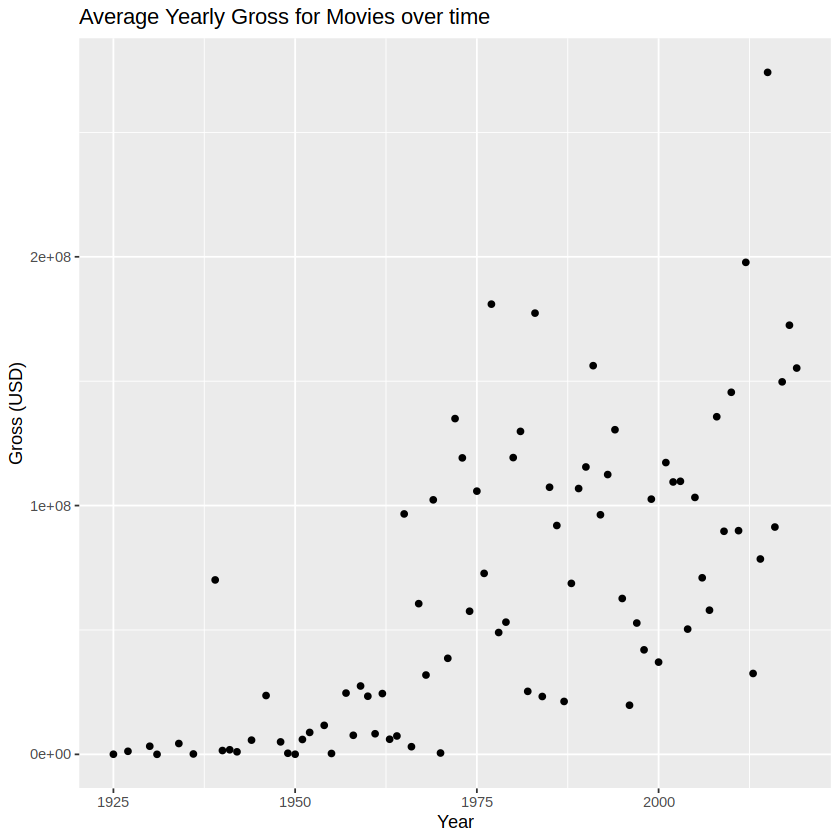

In [ ]:
movies <- movies |>
    select(Released_Year, Meta_score, Gross, Runtime) |>
    na.omit() |>
    mutate(Runtime = strtoi(Runtime %>% str_replace(" min", ""))) |>
    group_by(Released_Year) |>
    summarize(ave_Gross = mean(Gross), ave_runtime = mean(Runtime)*60) |>
    arrange(Released_Year)
movies
movies_plot <- movies |>
    ggplot(aes(Released_Year, ave_Gross)) +
        geom_point() +
        xlab("Year") +
        ylab("Gross (USD)") +
        ggtitle("Average Yearly Gross for Movies over time")
movies_plot
movies_plot_2 <- movies |>
    ggplot(aes(Released_Year, ave_runtime)) +
        geom_point() +
        xlab("Year") +
        ylab("Runtime (hours)") +
        ggtitle("Movie Length for Movies over time")
movies_plot_2

Methods:


Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

Expected outcomes and significance:


What do you expect to find?
What impact could such findings have?
What future questions could this lead to?